In [1]:
# # Enable remote debugging
# import debugpy
# import os

# # Only enable debugging if not already enabled
# if not debugpy.is_client_connected():
#     debugpy.listen(("localhost", 5678))
#     print("Waiting for debugger to attach...")
#     debugpy.wait_for_client()
#     print("Debugger attached!")

In [2]:
import networkx as nx
import nx_arangodb as nxadb

from arango import ArangoClient

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint
import re

from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_community.graphs import ArangoGraph
from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain
from langchain_core.tools import tool


import gradio as gr
from graph_utils import create_d3_visualization
from dotenv import load_dotenv
import os
from agent_utils import GraphAgent
import pprint



[01:14:23 -0600] [INFO]: NetworkX-cuGraph is unavailable: No module named 'nx_cugraph'.


In [3]:
load_dotenv()

True

In [4]:
# Access variables
openai_key = os.getenv('OPENAI_API_KEY')
arango_host = os.getenv('ARANGO_HOST')
arango_user = os.getenv('ARANGO_USER')
arango_password = os.getenv('ARANGO_PASSWORD')
arango_db = os.getenv('ARANGO_DB')


In [5]:
# Initialize the client for ArangoDB.
client = ArangoClient(hosts=arango_host)
db = client.db(arango_db, username=arango_user, password=arango_password)
print(db.collections())

[{'id': '195136', 'name': '_analyzers', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '195138', 'name': '_queues', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '195137', 'name': '_aqlfunctions', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '211044', 'name': 'Users', 'system': False, 'type': 'document', 'status': 'loaded'}, {'id': '195139', 'name': '_jobs', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '211045', 'name': 'Games', 'system': False, 'type': 'document', 'status': 'loaded'}, {'id': '195141', 'name': '_appbundles', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '195135', 'name': '_graphs', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '195140', 'name': '_apps', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '211046', 'name': 'plays', 'system': False, 'type': 'edge', 'status': 'loaded'}, {'id': '195142', 'name': '_frontend', 'system': True, 'type': 'docu

In [6]:

G_adb = nxadb.Graph(name="SteamGraph", db=db)

print(G_adb)

[01:14:27 -0600] [INFO]: Graph 'SteamGraph' exists.
[01:14:27 -0600] [INFO]: Default node type set to 'Games'


Graph named 'SteamGraph' with 14950 nodes and 70477 edges


In [7]:
graph_def = db.collection("_graphs").get("SteamGraph")
print(graph_def)


{'_key': 'SteamGraph', '_id': '_graphs/SteamGraph', '_rev': '_jQw_5k2---', 'edgeDefinitions': [{'collection': 'plays', 'from': ['Users'], 'to': ['Games']}], 'orphanCollections': [], 'networkx': {'name': 'SteamGraph'}}


In [8]:
for node, data in list(G_adb.nodes(data=True))[:10]:
    print(node, data.get("_id"))


Games/14454_speed_kills Games/14454_speed_kills
Users/194842424 Users/194842424
Users/179457413 Users/179457413
Games/13518_assault_android_cactus Games/13518_assault_android_cactus
Users/294155812 Users/294155812
Users/125654059 Users/125654059
Users/295723032 Users/295723032
Games/13527_unreal_tournament_game_of_the_year_edition Games/13527_unreal_tournament_game_of_the_year_edition
Users/58931437 Users/58931437
Users/198680785 Users/198680785


In [9]:
print(G_adb)

Graph named 'SteamGraph' with 14950 nodes and 70477 edges


### AQL Test

In [10]:
# First, let's check what collections exist
print("Available collections:")
for collection in db.collections():
    print(collection['name'])

# Get the graph to see its collections
graph = db.graph('SteamGraph')
print("\nGraph collections:")
print(graph.edge_definitions())

Available collections:
_analyzers
_queues
_aqlfunctions
Users
_jobs
Games
_appbundles
_graphs
_apps
plays
_frontend

Graph collections:
[{'edge_collection': 'plays', 'from_vertex_collections': ['Users'], 'to_vertex_collections': ['Games']}]


In [11]:


# -----------------------------------------------------------
# 1. Query 3 random nodes from the Users collection.
# -----------------------------------------------------------
result_cursor = G_adb.query("""
    FOR node IN Users
        SORT RAND()
        LIMIT 3
        RETURN node
""")
print("Sample Users Nodes:")
for node in result_cursor:
    print(node)
print('-'*10)

# -----------------------------------------------------------
# 2. Query 3 random edges from the plays edge collection.
# -----------------------------------------------------------
result_cursor = G_adb.query("""
    FOR edge IN plays
        SORT RAND()
        LIMIT 3
        RETURN edge
""")
print("Sample Plays Edges:")
for edge in result_cursor:
    print(edge)
print('-'*10)


Sample Users Nodes:
{'_key': '61834736', '_id': 'Users/61834736', '_rev': '_jPaYbmS-_T', 'type': 'Users', 'steamid': 61834736}
{'_key': '171594027', '_id': 'Users/171594027', '_rev': '_jPaYbi6-__', 'type': 'Users', 'steamid': 171594027}
{'_key': '113546110', '_id': 'Users/113546110', '_rev': '_jPaYbku-_Y', 'type': 'Users', 'steamid': 113546110}
----------
Sample Plays Edges:
{'_key': '58834', '_id': 'plays/58834', '_from': 'Users/266659008', '_to': 'Games/11359_team_fortress_2', '_rev': '_jPaYiZK--B', 'weight': 1.5}
{'_key': '65518', '_id': 'plays/65518', '_from': 'Users/126372451', '_to': 'Games/11371_dota_2', '_rev': '_jPaYitC--G', 'weight': 253}
{'_key': '33504', '_id': 'plays/33504', '_from': 'Users/38465050', '_to': 'Games/11470_portal', '_rev': '_jPaYg3C--a', 'weight': 0.6}
----------


### Agent

In [12]:
arango_graph = ArangoGraph(db)


In [13]:
# If the schema is exposed as an attribute
graph_schema = arango_graph.schema
pprint.pprint(graph_schema)


{'Collection Schema': [{'collection_name': 'Users',
                        'collection_type': 'document',
                        'document_properties': [{'name': '_key', 'type': 'str'},
                                                {'name': '_id', 'type': 'str'},
                                                {'name': '_rev', 'type': 'str'},
                                                {'name': 'type', 'type': 'str'},
                                                {'name': 'steamid',
                                                 'type': 'int'}],
                        'example_document': {'_id': 'Users/151603712',
                                             '_key': '151603712',
                                             '_rev': '_jPaYbhm---',
                                             'steamid': 151603712,
                                             'type': 'Users'}},
                       {'collection_name': 'Games',
                        'collection_type': 'docu

In [14]:
result_cursor =  G_adb.query("""
WITH Games, plays
FOR game IN Games 
  LET playerCount = (
    FOR play IN plays 
    FILTER play._to == game._id 
    COLLECT WITH COUNT INTO length 
    RETURN length
  )[0] 
  SORT playerCount DESC 
  LIMIT 1 
  RETURN {game, playerCount: playerCount}
""")

for item in result_cursor:
    print(item)
print('-'*10)



{'game': {'_key': '11371_dota_2', '_id': 'Games/11371_dota_2', '_rev': '_jPaYcPq--B', 'type': 'Games', 'GameName': 'Dota 2'}, 'playerCount': 4841}
----------


In [15]:
arango_graph

/home/manoj99/miniconda3/envs/Arrongo/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:502: UserWarning: <built-in function any> is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(


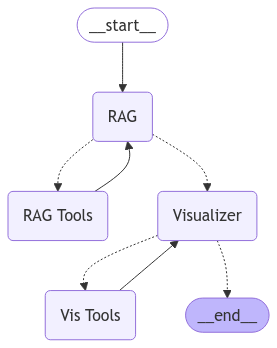

In [16]:
agent = GraphAgent(arango_graph, G_adb)


In [17]:
def create_gradio_interface(agent):
    def display_response(input_text):
        result = agent.query_graph(input_text)
        print("Inside interface")
        print(result["html_code"])
        return (
            result["html_code"],
            result["reply"]
        )
    
    css = """
        #visualization-container {
            width: 100%;
            margin: 0;
            padding: 0;
        }
        #visualization-container iframe {
            width: 100%;
            height: 600px;
            border: none;
        }
    """
    
    with gr.Blocks(css=css) as interface:
        gr.Markdown("# Graph Analysis Interface")
        
        with gr.Column():
            input_text = gr.Textbox(
                label="Query",
                placeholder="Enter your graph query here...",
                lines=2
            )
            
            submit_btn = gr.Button("Analyze", variant="primary")
            
            html_output = gr.HTML(
                label="Visualization",
                value="",
                elem_id="visualization-container"
            )
            
            text_output = gr.Textbox(
                label="Analysis Result", 
                lines=3
            )
            
        submit_btn.click(
            fn=display_response,
            inputs=[input_text],
            outputs=[html_output, text_output]
        )
    
    return interface

In [18]:
# Assuming G_adb is already defined and is a NetworkX Graph object
import networkx as nx

# Calculate degree centrality for all nodes
degree_centrality = nx.degree_centrality(G_adb)

# Filter out the game nodes
game_nodes = [node for node, data in G_adb.nodes(data=True) if data.get('type') == 'Games']

# Get the game with the highest degree centrality
most_influential_game = max(game_nodes, key=lambda node: degree_centrality.get(node, 0))

# Retrieve the node data for the most influential game
FINAL_RESULT = G_adb.nodes[most_influential_game]

[01:14:33 -0600] [INFO]: Graph 'SteamGraph' load took 2.464827299118042s


In [19]:
print(FINAL_RESULT)

{'GameName': 'Dota 2', '_id': 'Games/11371_dota_2', '_key': '11371_dota_2', 'type': 'Games'}


In [20]:
interface = create_gradio_interface(agent)
interface.launch()

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.



Processing Agent State:
{ 'data': [],
  'iframe_html': '',
  'messages': [ HumanMessage(content='total number of users who played the top 6 games in the graph', additional_kwargs={}, response_metadata={}, id='dbf7f1ed-92d4-46e1-86d0-12a76f369b58')],
  'user_query': 'total number of users who played the top 6 games in the graph'}


> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Games, plays
FOR game IN Games
LET playerCount = (
    FOR play IN plays
    FILTER play._to == game._id
    COLLECT WITH COUNT INTO length
    RETURN length
)[0]
SORT playerCount DESC
LIMIT 6
RETURN {game, playerCount: playerCount}

AQL Result:
[{'game': {'_key': '11371_dota_2', '_id': 'Games/11371_dota_2', '_rev': '_jPaYcPq--B', 'type': 'Games', 'GameName': 'Dota 2'}, 'playerCount': 4841}, {'game': {'_key': '11359_team_fortress_2', '_id': 'Games/11359_team_fortress_2', '_rev': '_jPaYcPm--H', 'type': 'Games', 'GameName': 'Team Fortress 2'}, 'playerCount': 2323}, {'game': {'_key': '11389_counter_

In [ ]:
response = agent.query_graph("Total number of games in the graph")

In [ ]:
agent.query_graph("Users who have played the most influential game")

In [ ]:
agent.query_graph("Find 2nd and 4th Most influential game in the graph and its number of users who played both of them")

In [ ]:
agent.query_graph("Find the  top 10 users who played a lot  and which games they have played is common most by hours")

In [ ]:
agent.query_graph("get me 10 random users")